# Esports World Map – Battle Royale

This notebook reproduces the **Battle Royale choropleth map**
using Python, pandas, GeoPandas, and Matplotlib.

It shows total esports prize earnings in the **Battle Royale** genre aggregated at the country level.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

## 1. Load game– and country–level data

We use two CSVs:
- `esports_games.csv`: global game information including **Genre** and **TotalEarnings**.
- `country_esports.csv`: country–game level prize money and player counts.


In [2]:
data_dir = Path('/mnt/data')
games_path = 'esports_games.csv'
country_path = 'country_esports.csv'

games_df = pd.read_csv(games_path)
country_df = pd.read_csv(country_path)

games_df.head(), country_df.head()

(                    Game  ReleaseDate     Genre  TotalEarnings  \
 0         Age of Empires         1997  Strategy      736284.75   
 1      Age of Empires II         1999  Strategy     3898508.73   
 2     Age of Empires III         2005  Strategy      122256.72   
 3      Age of Empires IV         2021  Strategy     1190813.44   
 4  Age of Empires Online         2011  Strategy       11462.98   
 
    OfflineEarnings  PercentOffline  TotalPlayers  TotalTournaments  
 0        522378.17        0.709478           624               341  
 1       1361409.22        0.349213          2256              1939  
 2         44472.60        0.363764           172               179  
 3        439117.93        0.368755           643               423  
 4           775.00        0.067609            52                68  ,
                     country  total_earnings  player_count               game  \
 0                     China    3.309117e+08          9333             Dota 2   
 1  United St

## 2. Filter for the *Battle Royale* genre and aggregate by country

We first find all games whose `Genre` is **Battle Royale**, then keep only rows in `country_esports.csv` that involve those games. For each country we sum:
- `game_earnings` → total prize earnings in this genre
- `player_count` → total number of players appearing in those game–country rows


In [3]:
# Normalise helper to be robust to whitespace / case
def norm(s):
    return str(s).strip().lower()

# 1) games in the Battle Royale genre
target_genre = 'Battle Royale'
battle_games = games_df[games_df['Genre'].apply(norm) == norm(target_genre)]['Game']
battle_games_set = set(battle_games)
print(f'Battle Royale games: {len(battle_games_set)}')

# 2) filter country-level rows to only these games
mask = country_df['game'].apply(norm).isin({norm(g) for g in battle_games_set})
battle_country = country_df[mask].copy()
print(f'Country–game rows for Battle Royale: {len(battle_country)}')

# 3) aggregate by country
agg = (
    battle_country
    .groupby('country', as_index=False)
    .agg(
        total_earnings_genre=('game_earnings', 'sum'),
        total_players_genre=('player_count', 'sum'),
        game_count=('game', 'nunique'),
    )
)

# sort by earnings for a quick sanity check
agg = agg.sort_values('total_earnings_genre', ascending=False)
agg.head(10)

Battle Royale games: 17
Country–game rows for Battle Royale: 57


,country,total_earnings_genre,total_players_genre,game_count
55,United States of America,52369833.18,29198,1
11,Canada,9174904.96,4361,1
54,United Kingdom,8783157.13,5672,1
30,Japan,5800971.79,3982,1
26,Indonesia,5106526.21,2650,1
6,Austria,3844467.67,745,1
25,India,3843448.97,1637,1
52,Turkey,3761651.81,1729,1
37,Netherlands,3549767.69,2237,1
40,Norway,3375189.68,1419,1


## 3. Join with world geometries

We use the built‑in **Natural Earth** country polygons that ship with GeoPandas, then left‑join our Battle Royale earnings per country. Any country with no data will appear in a neutral dark grey.

In [7]:
pip install geodatasets

In [11]:
import geopandas as gpd

# ✅ Load world countries GeoJSON directly from GitHub
world_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
world = gpd.read_file(world_url)

# Keep only what we need
world = world[['name', 'geometry']]

world.head()


,name,geometry
0,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


In [12]:
# Merge on country name. The CSV already uses Natural Earth‑style names
world_merged = world.merge(agg, how='left', left_on='name', right_on='country')
world_merged[['name', 'total_earnings_genre']].head(10)

,name,total_earnings_genre
0,Afghanistan,NaN
1,Angola,1200.00
2,Albania,44105.94
3,United Arab Emirates,NaN
4,Argentina,2642240.03
5,Armenia,NaN
6,Antarctica,NaN
7,French Southern and Antarctic Lands,NaN
8,Australia,NaN
9,Austria,3844467.67


## 4. Plot the Battle Royale choropleth map

- Fill colour encodes `total_earnings_genre` (darker → more prize money).
- Countries with no Battle Royale earnings in the dataset remain in a dark baseline colour.


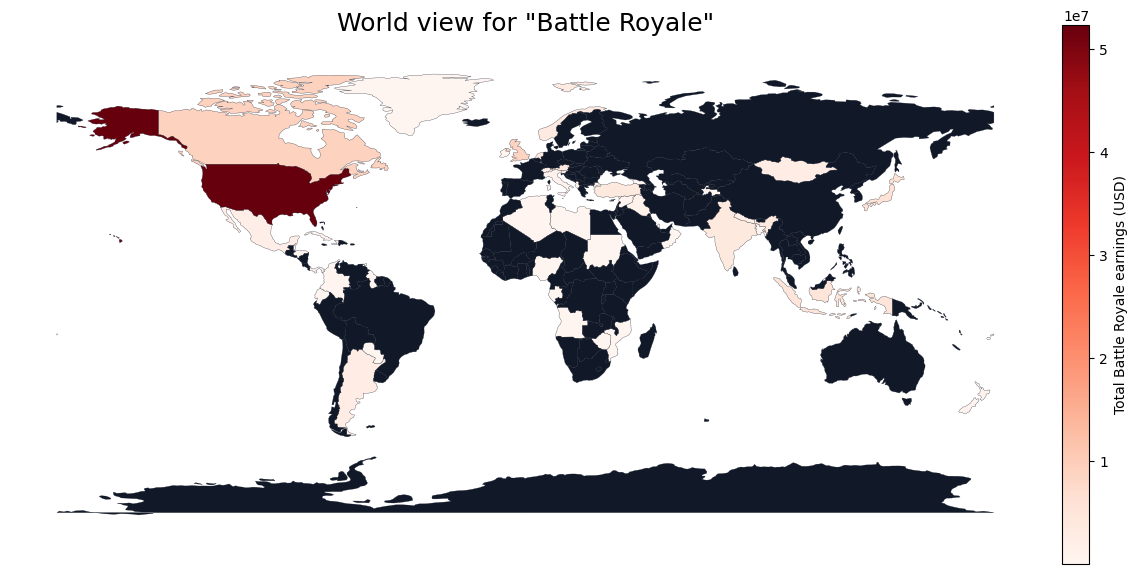

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))

# Base map
world_merged.plot(
    ax=ax,
    column='total_earnings_genre',
    cmap='Reds',
    linewidth=0.2,
    edgecolor='#111827',
    missing_kwds={
        'color': '#111827',  # dark grey for countries with no data
        'edgecolor': '#111827',
        'hatch': None,
    },
)

ax.set_title('World view for "Battle Royale"', fontsize=18, pad=15)
ax.set_axis_off()

# Add a simple colour bar
sm = plt.cm.ScalarMappable(cmap='Reds',
                           norm=plt.Normalize(
                               vmin=world_merged['total_earnings_genre'].min(),
                               vmax=world_merged['total_earnings_genre'].max(),
                           ))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Total Battle Royale earnings (USD)', fontsize=10)

plt.show()

## 5. Top Battle Royale countries

For reference, here are the top 10 countries by total Battle Royale earnings.

In [14]:
agg.head(10)

,country,total_earnings_genre,total_players_genre,game_count
55,United States of America,52369833.18,29198,1
11,Canada,9174904.96,4361,1
54,United Kingdom,8783157.13,5672,1
30,Japan,5800971.79,3982,1
26,Indonesia,5106526.21,2650,1
6,Austria,3844467.67,745,1
25,India,3843448.97,1637,1
52,Turkey,3761651.81,1729,1
37,Netherlands,3549767.69,2237,1
40,Norway,3375189.68,1419,1
